# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
#for i in range(1, 6):                                      # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
from datetime import datetime
import math

#temporary
#import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import copy
import random
import pickle
from models import *
import os

In [8]:
from models import *
#this contains actor_network and critic_network classes
#ddpg_Agent is a class for a single agent. It depends on num_agents as this dictates input size to critic

from agent import *
#contains ddpg_Agent and replay buffer classes. Also a noise generation function


In [9]:
HIDDEN_SIZE = 300

#Ornstein-Uhlenbeck Noise
OU_THETA = 0.15
OU_SIGMA = 0.2
#Decay amplitude of noise
NOISE_START = 1.5
NOISE_DECAY = 0.998
NOISE_END = 0.05
print('Takes %s decays for noise to reach %s'% (math.log((NOISE_END/NOISE_START),NOISE_DECAY), NOISE_END) )

REPLAY_MAX_SIZE = 1e5
BATCH_SIZE = 32 #256

GAMMA=0.99
CRITIC_LR = 1e-4
ACTOR_LR = 1e-4
TAU = 1e-3


N_RANDOM = 300
UPDATES_PER_STEP = 3

checkpoint_dir = "./checkpoints"
run_name = datetime.now().strftime('%Y%m%d_%H%M')
print('Run name = ',run_name)
SAVE_EVERY = 100

NUM_EPISODES = 1500



Takes 1698.8975247064295 decays for noise to reach 0.05
Run name =  20200527_1719


In [10]:
def timedelta_to_str(d):
    '''function to format a timedelta string nicely'''
    s = d.seconds
    h = math.floor(s/3600)
    m = math.floor((s-h*3600)/60)
    return('%sh %sm'%(h,m))

In [11]:
#train

maddpg = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents, 
                hidden1_size=HIDDEN_SIZE, hidden2_size=HIDDEN_SIZE, 
                max_replay_size=REPLAY_MAX_SIZE, batch_size=BATCH_SIZE,
                actor_lr=ACTOR_LR, critic_lr=CRITIC_LR, 
                gamma=GAMMA, tau=TAU)

score_history = []


start_time = datetime.now()

for episode in range(NUM_EPISODES):                                      
    env_info = env.reset(train_mode=False)[brain_name]       
    states = env_info.vector_observations                  
    #shape (2,24), (num_agents,state_size)
    scores = np.zeros(num_agents)   
    noise_generator = OU_Noise(action_size = action_size, num_agents=num_agents ,theta=OU_THETA,sigma=OU_SIGMA)
    ep = max(NOISE_START * NOISE_DECAY**episode, NOISE_END) #epsilon for exploration
    while True:
        if episode<N_RANDOM:
            actions  = np.random.randn(num_agents, action_size)
            actions = np.clip(actions, -1, 1)
        else:
            actions = maddpg.get_actions(states) # use actors to select action for each agent.size (num_agents, action_size)
            noise = ep * noise_generator.get_noise() #add noise
            actions = np.clip(actions+noise, -1, 1)
        
        env_info = env.step(actions)[brain_name]  
        
        next_states = env_info.vector_observations         
        rewards = env_info.rewards #list of length num_agents
        dones = env_info.local_done #list of length num_agents 
        
        maddpg.step(states,actions,rewards,next_states,dones,UPDATES_PER_STEP)
        
        scores += env_info.rewards 
        states = next_states
        if np.any(dones):                                  
            break
    #print('Score (max over agents) from episode {}: {}'.format(episode, np.max(scores)))
    
    score_history.append(np.max(scores))
    now_time = datetime.now()
    run_time = now_time-start_time
    forecast_time = (run_time / (episode + 1)) * (NUM_EPISODES - episode - 1)
    print('episode = %s, score = %.3f, running for: %s, time to go: %s'%(episode+1,np.max(scores),
                                                                    timedelta_to_str(run_time),
                                                                    timedelta_to_str(forecast_time)))
    
    if episode%SAVE_EVERY==0 and episode!=0:
        maddpg.checkpoint(run_name, checkpoint_dir, episode, scores = score_history)
        print('checkpoint saved ep',episode)
#Score (max over agents) from episode 1: 0.0

episode = 1, score = 0.100, running for: 0h 0m, time to go: 0h 34m
episode = 2, score = 0.000, running for: 0h 0m, time to go: 0h 39m
episode = 3, score = 0.000, running for: 0h 0m, time to go: 0h 42m
episode = 4, score = 0.000, running for: 0h 0m, time to go: 0h 42m
episode = 5, score = 0.000, running for: 0h 0m, time to go: 0h 43m
episode = 6, score = 0.000, running for: 0h 0m, time to go: 0h 43m
episode = 7, score = 0.000, running for: 0h 0m, time to go: 0h 49m
episode = 8, score = 0.000, running for: 0h 0m, time to go: 0h 48m
episode = 9, score = 0.100, running for: 0h 0m, time to go: 0h 54m
episode = 10, score = 0.000, running for: 0h 0m, time to go: 0h 53m
episode = 11, score = 0.000, running for: 0h 0m, time to go: 0h 52m
episode = 12, score = 0.000, running for: 0h 0m, time to go: 0h 51m
episode = 13, score = 0.000, running for: 0h 0m, time to go: 0h 50m
episode = 14, score = 0.000, running for: 0h 0m, time to go: 0h 50m
episode = 15, score = 0.000, running for: 0h 0m, time to 

episode = 121, score = 0.000, running for: 0h 5m, time to go: 1h 0m
episode = 122, score = 0.000, running for: 0h 5m, time to go: 1h 0m
episode = 123, score = 0.000, running for: 0h 5m, time to go: 1h 0m
episode = 124, score = 0.090, running for: 0h 5m, time to go: 1h 1m
episode = 125, score = 0.100, running for: 0h 5m, time to go: 1h 1m
episode = 126, score = 0.000, running for: 0h 5m, time to go: 1h 1m
episode = 127, score = 0.000, running for: 0h 5m, time to go: 1h 1m
episode = 128, score = 0.000, running for: 0h 5m, time to go: 1h 1m
episode = 129, score = 0.000, running for: 0h 5m, time to go: 1h 1m
episode = 130, score = 0.000, running for: 0h 5m, time to go: 1h 1m
episode = 131, score = 0.000, running for: 0h 5m, time to go: 1h 1m
episode = 132, score = 0.000, running for: 0h 5m, time to go: 1h 1m
episode = 133, score = 0.100, running for: 0h 5m, time to go: 1h 1m
episode = 134, score = 0.000, running for: 0h 6m, time to go: 1h 1m
episode = 135, score = 0.090, running for: 0h 6m

episode = 241, score = 0.000, running for: 0h 11m, time to go: 1h 1m
episode = 242, score = 0.000, running for: 0h 11m, time to go: 1h 1m
episode = 243, score = 0.090, running for: 0h 11m, time to go: 1h 1m
episode = 244, score = 0.000, running for: 0h 11m, time to go: 1h 1m
episode = 245, score = 0.000, running for: 0h 12m, time to go: 1h 1m
episode = 246, score = 0.000, running for: 0h 12m, time to go: 1h 1m
episode = 247, score = 0.000, running for: 0h 12m, time to go: 1h 1m
episode = 248, score = 0.000, running for: 0h 12m, time to go: 1h 1m
episode = 249, score = 0.000, running for: 0h 12m, time to go: 1h 1m
episode = 250, score = 0.000, running for: 0h 12m, time to go: 1h 1m
episode = 251, score = 0.000, running for: 0h 12m, time to go: 1h 1m
episode = 252, score = 0.100, running for: 0h 12m, time to go: 1h 1m
episode = 253, score = 0.000, running for: 0h 12m, time to go: 1h 1m
episode = 254, score = 0.000, running for: 0h 12m, time to go: 1h 1m
episode = 255, score = 0.000, runn

episode = 360, score = 0.000, running for: 0h 18m, time to go: 0h 59m
episode = 361, score = 0.000, running for: 0h 18m, time to go: 0h 59m
episode = 362, score = 0.000, running for: 0h 18m, time to go: 0h 59m
episode = 363, score = 0.000, running for: 0h 18m, time to go: 0h 59m
episode = 364, score = 0.000, running for: 0h 18m, time to go: 0h 59m
episode = 365, score = 0.000, running for: 0h 18m, time to go: 0h 59m
episode = 366, score = 0.000, running for: 0h 19m, time to go: 0h 58m
episode = 367, score = 0.000, running for: 0h 19m, time to go: 0h 58m
episode = 368, score = 0.000, running for: 0h 19m, time to go: 0h 58m
episode = 369, score = 0.000, running for: 0h 19m, time to go: 0h 58m
episode = 370, score = 0.000, running for: 0h 19m, time to go: 0h 58m
episode = 371, score = 0.000, running for: 0h 19m, time to go: 0h 58m
episode = 372, score = 0.000, running for: 0h 19m, time to go: 0h 58m
episode = 373, score = 0.000, running for: 0h 19m, time to go: 0h 58m
episode = 374, score

episode = 477, score = 0.000, running for: 0h 23m, time to go: 0h 51m
episode = 478, score = 0.000, running for: 0h 23m, time to go: 0h 50m
episode = 479, score = 0.000, running for: 0h 23m, time to go: 0h 50m
episode = 480, score = 0.000, running for: 0h 23m, time to go: 0h 50m
episode = 481, score = 0.000, running for: 0h 23m, time to go: 0h 50m
episode = 482, score = 0.000, running for: 0h 24m, time to go: 0h 50m
episode = 483, score = 0.000, running for: 0h 24m, time to go: 0h 50m
episode = 484, score = 0.000, running for: 0h 24m, time to go: 0h 50m
episode = 485, score = 0.000, running for: 0h 24m, time to go: 0h 50m
episode = 486, score = 0.000, running for: 0h 24m, time to go: 0h 50m
episode = 487, score = 0.000, running for: 0h 24m, time to go: 0h 50m
episode = 488, score = 0.000, running for: 0h 24m, time to go: 0h 50m
episode = 489, score = 0.000, running for: 0h 24m, time to go: 0h 50m
episode = 490, score = 0.000, running for: 0h 24m, time to go: 0h 50m
episode = 491, score

episode = 594, score = 0.000, running for: 0h 28m, time to go: 0h 43m
episode = 595, score = 0.000, running for: 0h 28m, time to go: 0h 43m
episode = 596, score = 0.000, running for: 0h 28m, time to go: 0h 43m
episode = 597, score = 0.000, running for: 0h 28m, time to go: 0h 43m
episode = 598, score = 0.000, running for: 0h 28m, time to go: 0h 43m
episode = 599, score = 0.000, running for: 0h 29m, time to go: 0h 43m
episode = 600, score = 0.000, running for: 0h 29m, time to go: 0h 43m
episode = 601, score = 0.000, running for: 0h 29m, time to go: 0h 43m
checkpoint saved ep 600
episode = 602, score = 0.000, running for: 0h 29m, time to go: 0h 43m
episode = 603, score = 0.000, running for: 0h 29m, time to go: 0h 43m
episode = 604, score = 0.000, running for: 0h 29m, time to go: 0h 43m
episode = 605, score = 0.000, running for: 0h 29m, time to go: 0h 43m
episode = 606, score = 0.000, running for: 0h 29m, time to go: 0h 43m
episode = 607, score = 0.000, running for: 0h 29m, time to go: 0h 

episode = 711, score = 0.000, running for: 0h 33m, time to go: 0h 37m
episode = 712, score = 0.000, running for: 0h 33m, time to go: 0h 37m
episode = 713, score = 0.000, running for: 0h 33m, time to go: 0h 37m
episode = 714, score = 0.000, running for: 0h 33m, time to go: 0h 37m
episode = 715, score = 0.000, running for: 0h 33m, time to go: 0h 37m
episode = 716, score = 0.000, running for: 0h 34m, time to go: 0h 37m
episode = 717, score = 0.000, running for: 0h 34m, time to go: 0h 37m
episode = 718, score = 0.000, running for: 0h 34m, time to go: 0h 37m
episode = 719, score = 0.000, running for: 0h 34m, time to go: 0h 37m
episode = 720, score = 0.000, running for: 0h 34m, time to go: 0h 37m
episode = 721, score = 0.000, running for: 0h 34m, time to go: 0h 36m
episode = 722, score = 0.000, running for: 0h 34m, time to go: 0h 36m
episode = 723, score = 0.000, running for: 0h 34m, time to go: 0h 36m
episode = 724, score = 0.000, running for: 0h 34m, time to go: 0h 36m
episode = 725, score

episode = 828, score = 0.000, running for: 0h 38m, time to go: 0h 31m
episode = 829, score = 0.000, running for: 0h 38m, time to go: 0h 31m
episode = 830, score = 0.000, running for: 0h 38m, time to go: 0h 31m
episode = 831, score = 0.000, running for: 0h 39m, time to go: 0h 31m
episode = 832, score = 0.000, running for: 0h 39m, time to go: 0h 31m
episode = 833, score = 0.000, running for: 0h 39m, time to go: 0h 31m
episode = 834, score = 0.000, running for: 0h 39m, time to go: 0h 31m
episode = 835, score = 0.000, running for: 0h 39m, time to go: 0h 31m
episode = 836, score = 0.000, running for: 0h 39m, time to go: 0h 31m
episode = 837, score = 0.000, running for: 0h 39m, time to go: 0h 31m
episode = 838, score = 0.000, running for: 0h 39m, time to go: 0h 31m
episode = 839, score = 0.000, running for: 0h 39m, time to go: 0h 31m
episode = 840, score = 0.000, running for: 0h 39m, time to go: 0h 30m
episode = 841, score = 0.000, running for: 0h 39m, time to go: 0h 30m
episode = 842, score

episode = 945, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 946, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 947, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 948, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 949, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 950, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 951, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 952, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 953, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 954, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 955, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 956, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 957, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 958, score = 0.000, running for: 0h 44m, time to go: 0h 25m
episode = 959, score

episode = 1061, score = 0.000, running for: 0h 48m, time to go: 0h 20m
episode = 1062, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episode = 1063, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episode = 1064, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episode = 1065, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episode = 1066, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episode = 1067, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episode = 1068, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episode = 1069, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episode = 1070, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episode = 1071, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episode = 1072, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episode = 1073, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episode = 1074, score = 0.000, running for: 0h 48m, time to go: 0h 19m
episod

episode = 1177, score = 0.000, running for: 0h 52m, time to go: 0h 14m
episode = 1178, score = 0.000, running for: 0h 52m, time to go: 0h 14m
episode = 1179, score = 0.000, running for: 0h 52m, time to go: 0h 14m
episode = 1180, score = 0.000, running for: 0h 52m, time to go: 0h 14m
episode = 1181, score = 0.000, running for: 0h 52m, time to go: 0h 14m
episode = 1182, score = 0.000, running for: 0h 52m, time to go: 0h 14m
episode = 1183, score = 0.000, running for: 0h 52m, time to go: 0h 14m
episode = 1184, score = 0.000, running for: 0h 53m, time to go: 0h 14m
episode = 1185, score = 0.000, running for: 0h 53m, time to go: 0h 14m
episode = 1186, score = 0.000, running for: 0h 53m, time to go: 0h 14m
episode = 1187, score = 0.000, running for: 0h 53m, time to go: 0h 14m
episode = 1188, score = 0.000, running for: 0h 53m, time to go: 0h 13m
episode = 1189, score = 0.000, running for: 0h 53m, time to go: 0h 13m
episode = 1190, score = 0.000, running for: 0h 53m, time to go: 0h 13m
episod

episode = 1293, score = 0.000, running for: 0h 57m, time to go: 0h 9m
episode = 1294, score = 0.000, running for: 0h 57m, time to go: 0h 9m
episode = 1295, score = 0.000, running for: 0h 57m, time to go: 0h 9m
episode = 1296, score = 0.000, running for: 0h 57m, time to go: 0h 9m
episode = 1297, score = 0.000, running for: 0h 57m, time to go: 0h 8m
episode = 1298, score = 0.000, running for: 0h 57m, time to go: 0h 8m
episode = 1299, score = 0.000, running for: 0h 57m, time to go: 0h 8m
episode = 1300, score = 0.000, running for: 0h 57m, time to go: 0h 8m
episode = 1301, score = 0.000, running for: 0h 57m, time to go: 0h 8m
checkpoint saved ep 1300
episode = 1302, score = 0.000, running for: 0h 57m, time to go: 0h 8m
episode = 1303, score = 0.000, running for: 0h 57m, time to go: 0h 8m
episode = 1304, score = 0.000, running for: 0h 57m, time to go: 0h 8m
episode = 1305, score = 0.000, running for: 0h 57m, time to go: 0h 8m
episode = 1306, score = 0.000, running for: 0h 57m, time to go: 0

episode = 1410, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1411, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1412, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1413, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1414, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1415, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1416, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1417, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1418, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1419, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1420, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1421, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1422, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1423, score = 0.000, running for: 1h 1m, time to go: 0h 3m
episode = 1424, score = 0.000, run

In [12]:
#scores =maddpg.load_checkpoint(run_name, checkpoint_dir, ep_no=4, scores=True)

In [13]:
def moving_average(a, n) :
    '''
    Calculates the moving average of an input list a, over a window of size n. 
    Returns the array of averages and the position of the final value in the window for each value
    '''
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ave = ret[n - 1:] / n
    inds = list(range(n,len(ave)+n))
    return(ave,inds)

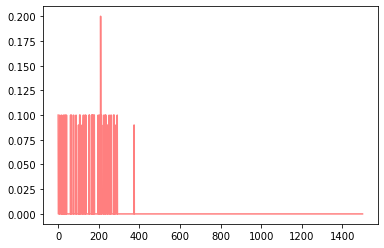

In [14]:
import matplotlib.pyplot as plt

smooth_period = 5
colour='r'

plt.plot(score_history,color=colour,alpha=0.5)
ave, inds = moving_average(score_history,smooth_period)
#plt.plot(inds,ave,color=colour)
plt.show()